In [16]:
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from himalaya.backend import set_backend
from matplotlib import axes

from compare_variance_residual.simulation import generate_dataset

In [17]:
backend = set_backend("cupy", on_error="warn")
warnings.filterwarnings("ignore")
plt.style.use("nord")
sns.set_theme()
random.seed(42)

In [18]:
def generic_errorbar_plot(data, horizontal_positions, title, suptitle, ylabel, xlabel, ax, fig):
    colors = sns.color_palette("muted", len(data['feature'].unique()))
    g = sns.barplot(data=data, x="feature", y='r2', ax=ax, palette=colors)

    # Annotating bar heights with their values (centered inside the bar)
    for container in g.containers:
        for bar in container:
            height = bar.get_height()
            if not np.isnan(height):  # Avoid labels for missing bars
                ax.annotate(f"{height:.2f}",
                            xy=(bar.get_x() + bar.get_width() / 2, height / 2),  # Centered position
                            ha='center', va='center', fontsize=8, color='white')  # Adjust color for contrast

    # Plot horizontal lines
    for i, (y_value, label, start, end) in enumerate(horizontal_positions):
        ax.hlines(y=y_value, xmin=start, xmax=end, colors='gray', linestyles='--', linewidth=1.5)
        ax.text((start + end) / 2, y_value, label, ha='center', va='bottom', fontsize=9, color='black')

    ax.set_title(title, fontsize=12)
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    fig.suptitle(suptitle, fontsize=14)

In [19]:
feature_space_dimensions = [
    100,  # shared
    100,  # unique 0
    100,  # unique 1
]
scalars = [0.6, 0.3, 0.1
]
n_targets = 1000
n_samples_train = 10000
n_samples_test = 1000
n_samples = n_samples_train + n_samples_test
noise_scalar = 0.1

cv = 20
alphas = np.logspace(-4, 4, 10)

In [20]:
Xs, Y = generate_dataset(feature_space_dimensions, scalars, n_targets, n_samples, noise_scalar)

In [21]:
scalars_alt = [0.6, 0.3, 0.1]
scalars_alt = scalars
Xs_alt, Y_alt = generate_dataset(feature_space_dimensions, scalars_alt, n_targets, n_samples, noise_scalar,
                                 shuffle=False)

# Variance Partitioning

In [22]:
def vp_errorbar(score_0, score_1, joint_score, shared, x0_unique, x1_unique, feature_space_dimensions, scalars,
                noise_scalar, ax: axes.Axes = None, fig=None):
    scores = [score_0, score_1, joint_score, shared, x0_unique, x1_unique]

    bar_names = [r"$X_1$", r"$X_2$", r"$X_1 \cup X_2$", r"$X_1 \cap X_2$", r"$X_1 \setminus X_2$",
                 r"$X_2 \setminus X_1$"]
    data = pd.DataFrame({
        "r2": np.concatenate(scores),
        "feature": np.repeat(bar_names, [len(s) for s in scores])
    })

    # Horizontal line positions
    horizontal_positions = [
        (scalars[0] + scalars[1], r"$a_S + a_{U_0}$", -0.50, 0.50),
        (scalars[0] + scalars[2], r"$a_S + a_{U_1}$", 0.50, 1.50),
        (sum(scalars), r"$a_S + a_{U_0} + a_{U_1}$", 1.50, 2.50),
        (scalars[0], r"$a_S$", 2.50, 3.50),
        (scalars[1], r"$a_{U_0}$", 3.50, 4.50),
        (scalars[2], r"$a_{U_1}$", 4.50, 5.50)
    ]

    # Call the generic function
    generic_errorbar_plot(
        data=data,
        horizontal_positions=horizontal_positions,
        title=fr"$a_S$: {scalars[0]:.2f}, $a_{{U_0}}$: {scalars[1]:.2f}, $a_{{U_1}}$: {scalars[2]:.2f}, $|S|$: {feature_space_dimensions[0]}, $|U_0|$: {feature_space_dimensions[1]}, $|U_1|$: {feature_space_dimensions[2]}, $a_E$: {noise_scalar}",
        suptitle="Variance partitioning",
        ylabel=r"Average Variance Explained ($r^2$)",
        xlabel="Feature space",
        ax=ax,
        fig=fig
    )

In [23]:
from compare_variance_residual.variance_partitioning import variance_partitioning

In [24]:
(score_0, score_1, joint_score, shared, x0_unique, x1_unique) = variance_partitioning(
    Xs, Y, n_samples_train, cv=cv, alphas=alphas
)

In [25]:
(score_0_alt, score_1_alt, joint_score_alt, shared_alt, x0_unique_alt, x1_unique_alt) = variance_partitioning(
    Xs_alt, Y_alt, n_samples_train, alphas, cv
)

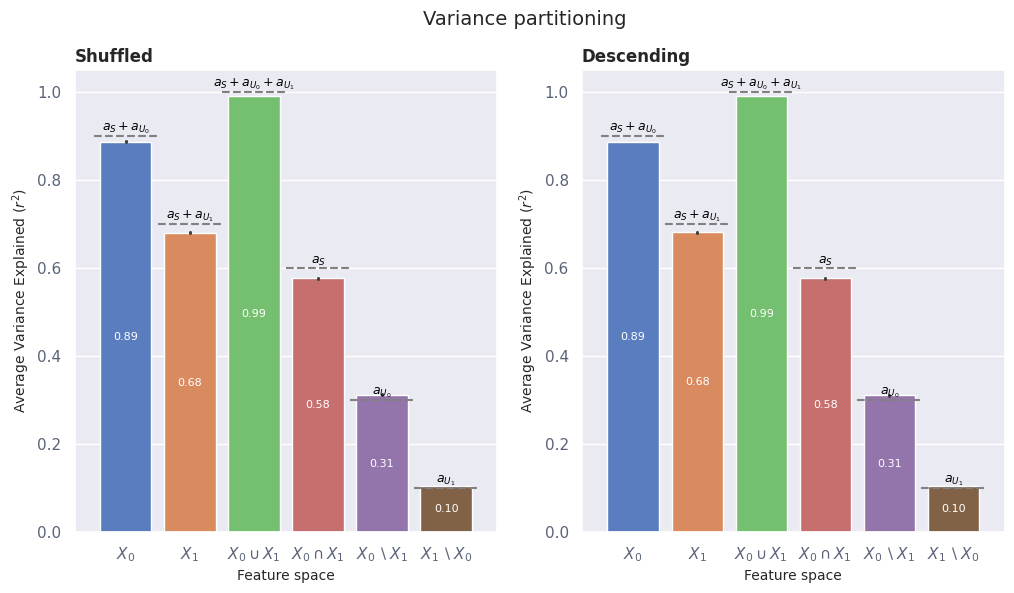

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

vp_errorbar(score_0, score_1, joint_score, shared, x0_unique, x1_unique, feature_space_dimensions, scalars,
            noise_scalar, ax=axs[0], fig=fig)
axs[0].set_title("Shuffled")

vp_errorbar(score_0_alt, score_1_alt, joint_score_alt, shared_alt, x0_unique_alt, x1_unique_alt,
            feature_space_dimensions, scalars_alt, noise_scalar, ax=axs[1], fig=fig)
axs[1].set_title("Descending")

plt.show()

# Residual Method

In [27]:
from compare_variance_residual.residual import residual_method

In [28]:
def rm_errorbar(full_score_0, full_score_1, feature_score_0, feature_score_1, residual_score_0, residual_scores_1,
                feature_space_dimensions, scalars, n_targets, noise_scalar, ax: axes.Axes = None, fig=None):
    if ax is None or fig is None:
        fig, ax = plt.subplots()

    # Precompute means and variances
    scores = [full_score_0, full_score_1, feature_score_0, feature_score_1, residual_score_0, residual_scores_1]

    bar_names = [r"$X_1$", r"$X_2$", r"$X_2 \rightarrow X_1$", r"$X_1 \rightarrow X_2$", r"$X_1 \setminus X_2$",
                 r"$X_2 \setminus X_1$"]
    data = pd.DataFrame({
        "r2": np.concatenate(scores),
        "feature": np.repeat(bar_names, [len(s) for s in scores])
    })

    horizontal_positions = [
        (scalars[0] + scalars[1], r"$a_S + a_{U_0}$", -0.5, 0.5),
        (scalars[0] + scalars[2], r"$a_S + a_{U_1}$", 0.5, 1.5),
        (feature_space_dimensions[0] / (feature_space_dimensions[0] + feature_space_dimensions[1]),
         r"$\frac{|S|}{|U_0|+|S|}$", 1.5, 2.5),
        (feature_space_dimensions[0] / (feature_space_dimensions[0] + feature_space_dimensions[2]),
         r"$\frac{|S|}{|U_1|+|S|}$", 2.5, 3.5),
        (scalars[1], r"$a_{U_0}$", 3.5, 4.5),
        (scalars[2], r"$a_{U_1}$", 4.5, 5.5)
    ]

    # Call the generic_errorbar function with the required data and parameters
    generic_errorbar_plot(
        data=data,
        horizontal_positions=horizontal_positions,
        title=fr"{n_targets} targets, $a_S$: {scalars[0]:.2f}, $|S|$: {feature_space_dimensions[0]}, $a_{{U_0}}$: {scalars[1]:.2f}, $|U_0|$: {feature_space_dimensions[1]}, $a_{{U_1}}$: {scalars[2]:.2f}, $|U_1|$: {feature_space_dimensions[2]}, $a_E$: {noise_scalar}",
        suptitle="Residual Method",
        ylabel=r"Average Variance Explained ($r^2$)",
        xlabel="Feature space/Model",
        ax=ax,
        fig=fig
    )

In [29]:
full_score_0, full_score_1, feature_score_0, feature_score_1, residual_score_0, residual_scores_1 = residual_method(
    Xs, Y, n_samples_train, cv=cv
)
full_score_0_alt, full_score_1_alt, feature_score_0_alt, feature_score_1_alt, residual_score_0_alt, residual_scores_1_alt = residual_method(
    Xs_alt, Y_alt, n_samples_train, cv=cv
)

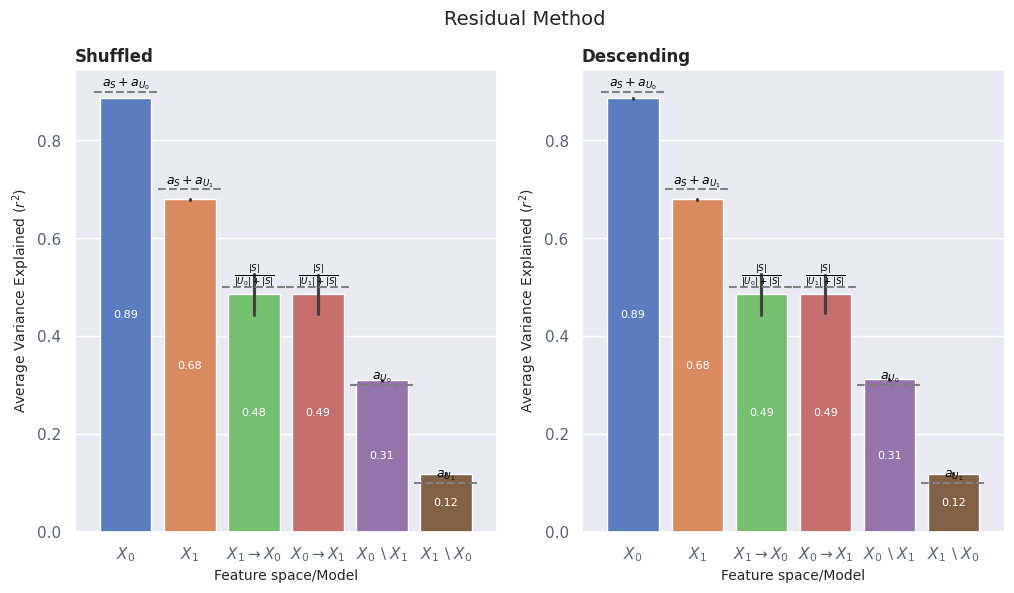

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

rm_errorbar(full_score_0, full_score_1, feature_score_0, feature_score_1, residual_score_0, residual_scores_1,
            feature_space_dimensions, scalars, n_targets, noise_scalar, ax=axs[0],
            fig=fig)
axs[0].set_title("Shuffled")
rm_errorbar(full_score_0_alt, full_score_1_alt, feature_score_0_alt, feature_score_1_alt, residual_score_0_alt,
            residual_scores_1_alt, feature_space_dimensions, scalars_alt, n_targets,
            noise_scalar, ax=axs[1], fig=fig)
axs[1].set_title("Descending")

plt.show()